## Architecture Flow

1. Feature Extraction using VGG16 --> Extract Embeddings from each image
2. Perform Aggregations --> Multiple images from different angles of a different shoe is aggregated to 'summarize' features. In this particular notebook, mean and max is performed. 
3. Compute Cosine Similarity with user input.

### Current Advantage of this Approach
1. Able to recognize inputs from various angles.
2. Able to recommend very similar shoes (if exist in database) based on style, color, and shape. If the price of these shoes are different, it may allow the user to choose relevant shoes with a lower budget.

### Room for Improvements

1. Experiment on Feature Extractor (ResNet, CLIP, etc.)
2. Use augmentation to enrich dataset
3. Currently, simple statistical aggregations are performed.

- Pros: No extra training, simple, lightweight, fast. 
- Cons: Might lose important features during aggregation. 

    For future iterations, employing attention-based models for a more representative embedding per sneaker

4. Adding additional criterias (user preferences, price, other similarities) for more refined relevance

In [3]:
import os 

# len(os.listdir('pics/')[0]

database = 'pics/'
for shoe in range(0, len(os.listdir(database))):
    print(os.listdir(database)[shoe])
    current_shoe_path = database + os.listdir(database)[0] 
    print(os.listdir(current_shoe_path))

Air Jordan 1 Low Black White Grey
['img5.jpg', 'img15.jpg', 'img25.jpg', 'img1.jpg', 'img35.jpg', 'img30.jpg', 'img10.jpg', 'img20.jpg']
Nike Dunk Low UNC 2021
['img5.jpg', 'img15.jpg', 'img25.jpg', 'img1.jpg', 'img35.jpg', 'img30.jpg', 'img10.jpg', 'img20.jpg']
Nike Air Force 1 Low College Pack Midnight Navy
['img5.jpg', 'img15.jpg', 'img25.jpg', 'img1.jpg', 'img35.jpg', 'img30.jpg', 'img10.jpg', 'img20.jpg']
adidas Gazelle Indoor Blue Fusion Gum W
['img5.jpg', 'img15.jpg', 'img25.jpg', 'img1.jpg', 'img35.jpg', 'img30.jpg', 'img10.jpg', 'img20.jpg']
adidas Yeezy Slide Resin 2022
['img5.jpg', 'img15.jpg', 'img25.jpg', 'img1.jpg', 'img35.jpg', 'img30.jpg', 'img10.jpg', 'img20.jpg']
New Balance 9060 Rain Cloud Grey
['img5.jpg', 'img15.jpg', 'img25.jpg', 'img1.jpg', 'img35.jpg', 'img30.jpg', 'img10.jpg', 'img20.jpg']
New Balance 550 White Grey Dark Grey
['img5.jpg', 'img15.jpg', 'img25.jpg', 'img1.jpg', 'img35.jpg', 'img30.jpg', 'img10.jpg', 'img20.jpg']
Air Jordan 1 Low Vintage UNC Grey


In [ ]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import cv2
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image as keras_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm 


output_folder = "augmented_pics/"  
os.makedirs(output_folder, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

# OPTION 2
# datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.1,
#     height_shift_range=0.2,
#     shear_range=0.3,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     brightness_range=(0.8, 1.2),
#     fill_mode='nearest'
# )

# Process each shoe folder
for shoe_model in tqdm(os.listdir(database)):
    shoe_path = os.path.join(database, shoe_model)
    augmented_shoe_path = os.path.join(output_folder, shoe_model)

    # Ensure the augmented folder exists
    if not os.path.exists(augmented_shoe_path):
        os.makedirs(augmented_shoe_path)

    # Augment each image
    for img_name in os.listdir(shoe_path):
        img_path = os.path.join(shoe_path, img_name)
        image = cv2.imread(img_path)
        if image is None:
            continue  # Skip unreadable images
        
        # Convert to RGB and reshape for augmentation
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.expand_dims(image, axis=0)

        # Generate augmented images (5 per original)
        i = 0
        for batch in datagen.flow(image, batch_size=1, save_to_dir=augmented_shoe_path,
                                  save_prefix=f"{img_name.split('.')[0]}_aug",
                                  save_format="jpeg"):
            i += 1
            if i == 5:  # Save 5 augmented versions per original
                break

100%|██████████| 334/334 [17:12<00:00,  3.09s/it]


Feature Extraction

___

In [ ]:
# Define paths
database_original = "pics/"
database_augmented = "augmented_pics/"

# Load VGG16 model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False)
model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

def extract_features(img_path):
    img = keras_img.load_img(img_path, target_size=(224, 224))  # Resize
    img_array = keras_img.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dim
    img_array = preprocess_input(img_array)  # Normalize for VGG16
    features = model.predict(img_array)  # Extract features
    return features.flatten()  # Flatten feature map

sneaker_features = {}

# Iterate over original sneaker folders
for sneaker_name in os.listdir(database_original):
    original_path = os.path.join(database_original, sneaker_name)
    augmented_path = os.path.join(database_augmented, sneaker_name)
    
    if os.path.isdir(original_path):  # Ensure it's a directory
        all_features = []
        
        # Create a mapping of original image prefixes (e.g., img1, img5)
        image_prefix_map = {}
        
        # Process original images
        for img_name in os.listdir(original_path):
            img_prefix = img_name.split('.')[0]  # Extract prefix (e.g., "img1")
            img_path = os.path.join(original_path, img_name)
            image_prefix_map.setdefault(img_prefix, []).append(img_path)
        
        # Process augmented images if available
        if os.path.exists(augmented_path):
            for img_name in os.listdir(augmented_path):
                img_prefix = "_".join(img_name.split("_")[:2])  # Extract base prefix (e.g., "img1_aug")
                img_path = os.path.join(augmented_path, img_name)
                image_prefix_map.setdefault(img_prefix, []).append(img_path)
        
        # Extract features for all images of the sneaker
        for img_paths in image_prefix_map.values():
            for img_path in img_paths:
                features = extract_features(img_path)
                all_features.append(features)

        # Convert to NumPy array
        all_features = np.array(all_features)

        # Average Pooling
        avg_embedding = np.mean(all_features, axis=0)

        # Max Pooling
        max_embedding = np.max(all_features, axis=0)

        # Store embeddings
        sneaker_features[sneaker_name] = {"avg": avg_embedding, "max": max_embedding}

# Function to find similar sneakers using cosine similarity
def find_similar_sneakers(query_img_path, method="avg", top_k=3):
    query_features = extract_features(query_img_path)
    similarities = []

    for sneaker_name, embeddings in sneaker_features.items():
        sneaker_embedding = embeddings[method]
        similarity = cosine_similarity([query_features], [sneaker_embedding])[0][0]
        similarities.append((sneaker_name, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [6]:
# Example usage
query_img = "pics/adidas Campus 80s South Park Towelie/img1.jpg" 
print("Top-3 Sneakers (Avg Pooling):", find_similar_sneakers(query_img, method="avg"))
print("Top-3 Sneakers (Max Pooling):", find_similar_sneakers(query_img, method="max"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
Top-3 Sneakers (Avg Pooling): [('adidas Campus 80s South Park Towelie', np.float32(0.545104)), ('adidas Samba OG Cloud White Core Black', np.float32(0.5115755)), ('adidas Samba Vegan Black Gum', np.float32(0.50390714))]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Top-3 Sneakers (Max Pooling): [('adidas Campus 80s South Park Towelie', np.float32(0.38670298)), ('adidas Samba Vegan White Gum', np.float32(0.36707234)), ('adidas Samba OG Cloud White Core Black', np.float32(0.36509994))]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


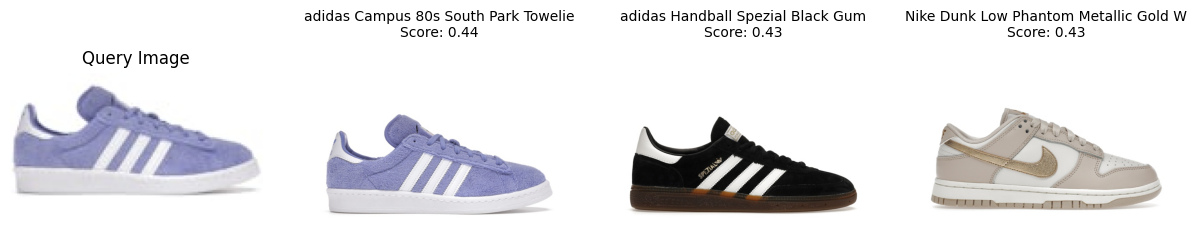

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


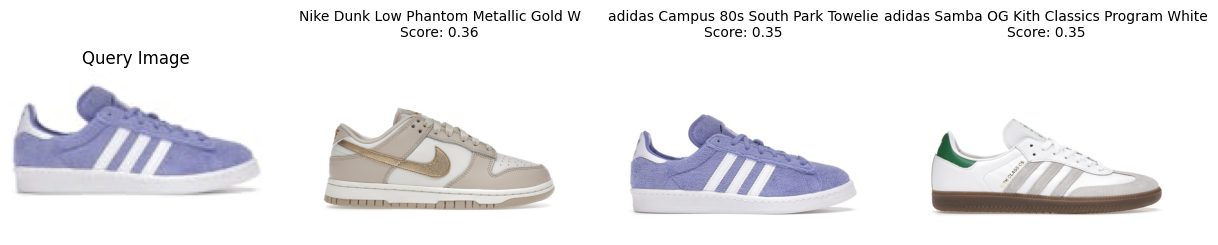

In [17]:
import matplotlib.pyplot as plt
import cv2

# Function to display query and top-3 retrieved sneakers
def display_results(query_img_path, method="avg", top_k=3):
    results = find_similar_sneakers(query_img_path, method=method, top_k=top_k)

    # Load and show the query image
    query_img = cv2.imread(query_img_path)
    query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 5))  # Create subplots
    axes[0].imshow(query_img)
    axes[0].set_title("Query Image", fontsize=12)
    axes[0].axis("off")

    # Load and show the top-k retrieved sneakers
    for i, (sneaker_name, similarity) in enumerate(results):
        sneaker_img_path = os.path.join(database, sneaker_name, "img1.jpg")  # Show 1st image
        retrieved_img = cv2.imread(sneaker_img_path)
        retrieved_img = cv2.cvtColor(retrieved_img, cv2.COLOR_BGR2RGB)

        axes[i + 1].imshow(retrieved_img)
        axes[i + 1].set_title(f"{sneaker_name}\nScore: {similarity:.2f}", fontsize=10)
        axes[i + 1].axis("off")

    plt.show()

# Example usage
query_img = "feetflix/adidas Campus 80s South Park Towelie.jpg"
display_results(query_img, method="avg")
display_results(query_img, method="max")